In [1]:
# This tutorial shows how to use CytoTRACE kernal (not RNA velocity) to address cell lineage question, it can draw velocity-like map
# which kernel to use depends on your biological system:
    # if RNA velocity works well you can use that
    # if RNA velocity not well, see whether you can get a good pseudotime using any pseudotime algorithm and feed that into the PseudotimeKernel
    # If you don’t have a good pseudotime, maybe because the root cell is unclear, try the CytoTRACEKernel
# every kernel object can visualize its transition matrix through scVelo-like arrows in an embedding, or through a set of simulated random walks
# every estimator works with every kernel

In [2]:
# CytoTRACE tells the differentiating status of cells.
# scv.pl.velocity_embedding_stream() draws the directions based on the concept that cells should initiate from undifferented status to differentiated status.
# However, if the cells can become dedifferentiated, then the inferred directions are inverted from the real directions.
# So we need to do the real experiment to validate any differentiating direction hypothesis, no matter RNA velocity inferred or CytoTRACE inferred, especially for cancer.

In [3]:
# code flow:

# prepare data for CytoTRACEKernel

# import CytoTRACEKernel
# ctk.compute_transition_matrix()
    # ctk.compute_projection()
    # scv.pl.velocity_embedding_stream()
# import estimator
# estimator.compute_schur()
# estimator.compute_macrostates()

# try all 3, choose the best fit one, funtion is like cr.tl.terminal_states()
    # estimator.compute_terminal_states()
    # estimator.set_terminal_states_from_macrostates()
    # estimator.set_terminal_states()

# try all 2, choose the best fit one, funtion is like cr.tl.initial_states()
    # estimator._compute_initial_states()
    # estimator._set_initial_states_from_macrostates()

# use this, funtion is like cr.tl.lineages()
    # estimator.compute_absorption_probabilities()

In [4]:
import sys
if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank@dev

In [5]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
scv.settings.verbosity = 3
scv.settings.set_figure_params(style="scvelo", dpi=100, dpi_save=600)
cr.settings.verbosity = 3

In [6]:
# 1. load data, note that this is CytoTRACE, we dont need spliced/unspliced information here
adata = cr.datasets.zebrafish()
adata    # this sample data already has 'force_directed' embedding inside, obs['Stage'] and obs['lineages'] is like obs['leiden'], obsm['X_force_directed'] is like obsm['X_umap']

AnnData object with n_obs × n_vars = 2434 × 23974
    obs: 'Stage', 'gt_terminal_states', 'lineages'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors'
    obsm: 'X_force_directed'

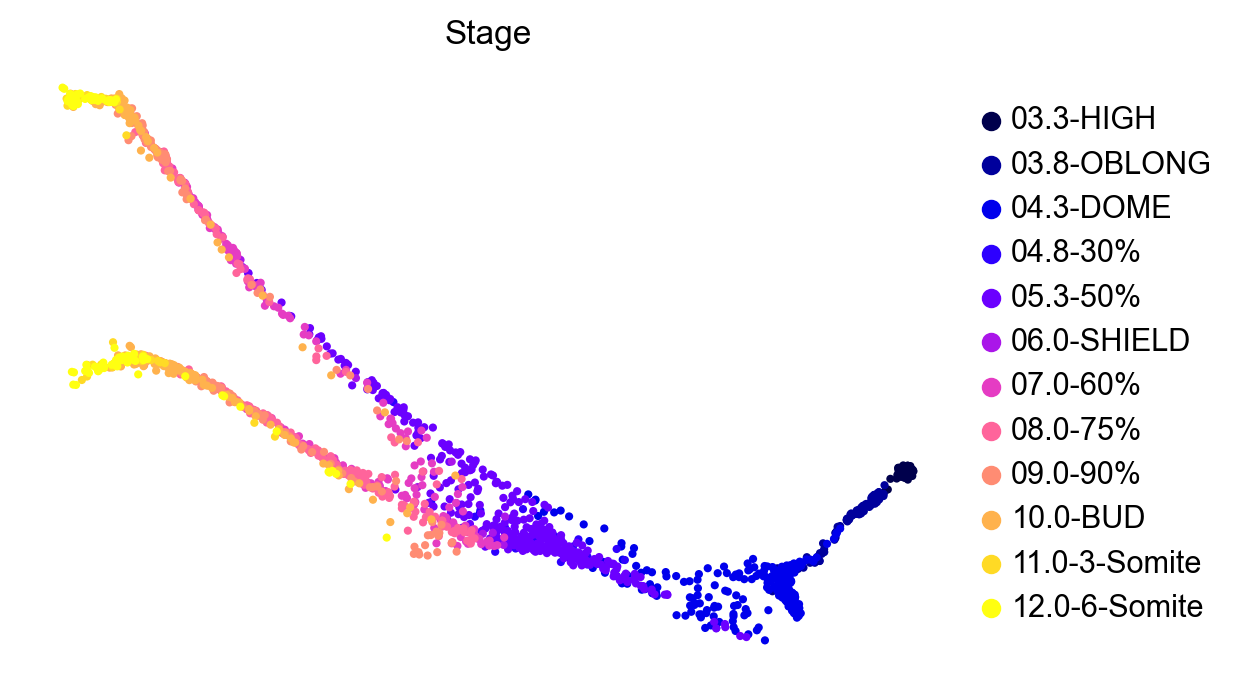

In [7]:
# check embedding clustered by Stage
scv.pl.scatter(adata, basis="force_directed", c="Stage", legend_loc="right")

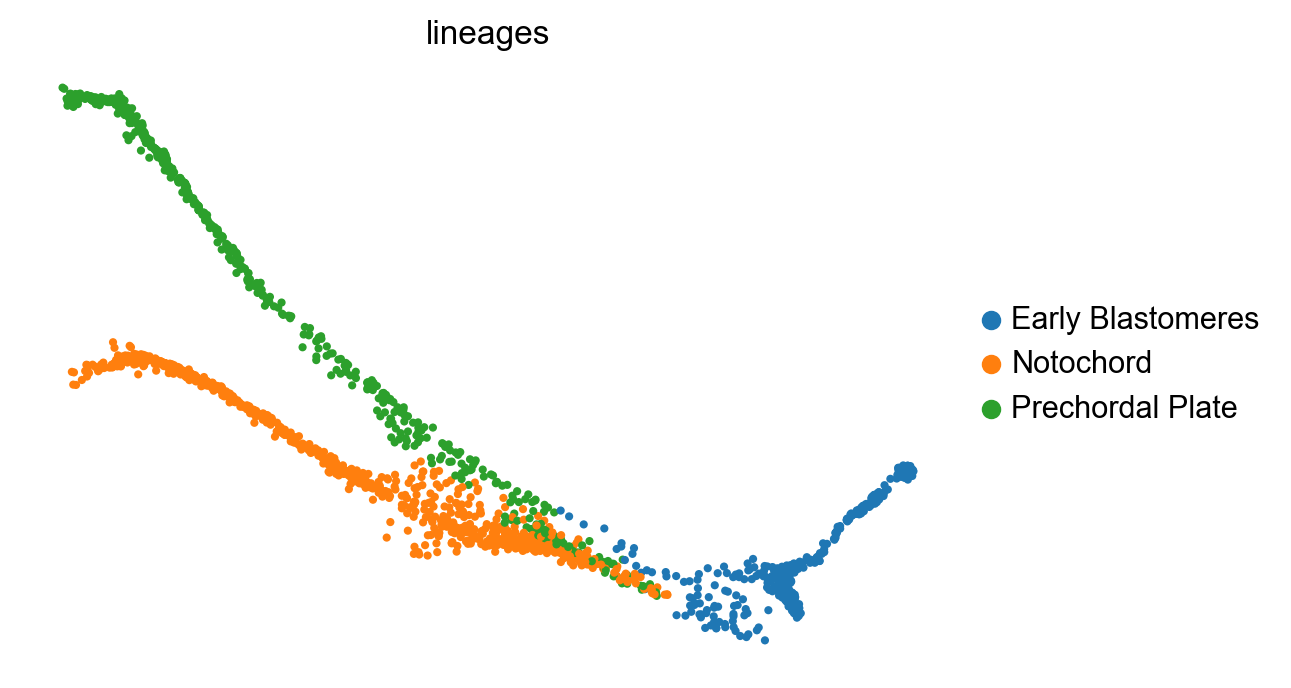

In [8]:
# check embedding clustered by lineages
scv.pl.scatter(adata, basis="force_directed", c="lineages", legend_loc="right")

In [9]:
# 2. Pre-process the data
# the same workflow as Scanpy: filter cells and genes, normalize by counts, logarithmize X (log1p), then select HVGs based on logarithmized matrix X, so we can copy the same coding from Scanpy
sc.pp.filter_genes(adata, min_cells=10)
scv.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)    # here only show how many HVGs are detected, but doesnt slice HVGs for downstream CytoTRACE, then CytoTRACE will use all genes to calculate ct_pseudotime, which includes a lot of noise and make the directions not smooth, I recommend to do adata = adata[:, adata.var.highly_variable] if too much noise 
print(f"This detected {np.sum(adata.var['highly_variable'])} highly variable genes. ")
## adata = adata[:, adata.var.highly_variable] if too much noise of directions
adata
# these codes return
# obs: 'n_counts'
# var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
# uns: 'log1p', 'hvg'

Normalized count data: X.
This detected 2392 highly variable genes. 


AnnData object with n_obs × n_vars = 2434 × 13690
    obs: 'Stage', 'gt_terminal_states', 'lineages', 'n_counts'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors', 'log1p', 'hvg'
    obsm: 'X_force_directed'

In [10]:
# copy matrix X into the layers because that's where scv.pp.moments() expects to find counts for imputation
# note that CytoTRACE is based on the gene counts, no need for spliced/unspliced information
# Here, copy matrix X into adata.layers (not the real spliced/unspliced information) is only for the function of scv.pp.moments() to calculate the moments of matrix X abundances
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata
# these codes return
# uns: 'pca', 'neighbors'
# obsm: 'X_pca'
# varm: 'PCs'
# layers: 'spliced', 'unspliced', 'Ms', 'Mu'
# obsp: 'distances', 'connectivities'

computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


AnnData object with n_obs × n_vars = 2434 × 13690
    obs: 'Stage', 'gt_terminal_states', 'lineages', 'n_counts'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors', 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_force_directed', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [11]:
# 3. Initialize the CytoTRACE kernel
from cellrank.tl.kernels import CytoTRACEKernel
ctk = CytoTRACEKernel(adata)
adata
# these codes return
# obs: 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime'
# var: 'ct_gene_corr', 'ct_correlates'
# uns: 'ct_params'

Computing CytoTRACE score with `13690` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)


AnnData object with n_obs × n_vars = 2434 × 13690
    obs: 'Stage', 'gt_terminal_states', 'lineages', 'n_counts', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ct_gene_corr', 'ct_correlates'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'ct_params'
    obsm: 'X_force_directed', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

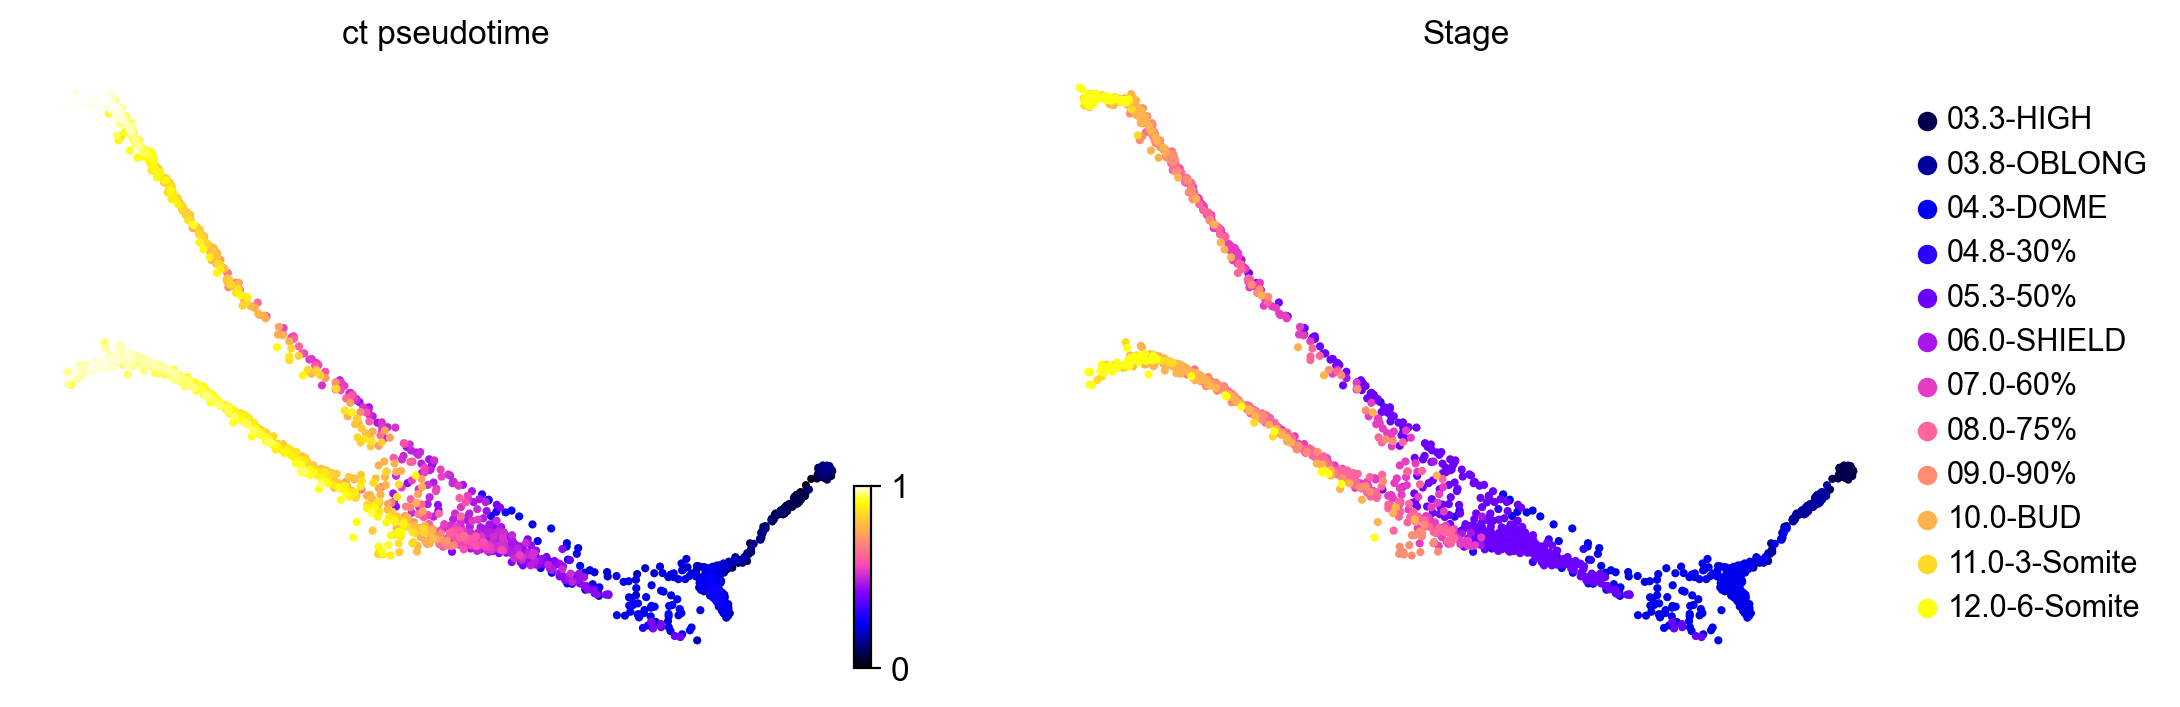

In [12]:
# compare CytoTRACE pesudotime with the real differentiation status
scv.pl.scatter(adata, color=["ct_pseudotime", "Stage"], basis="force_directed", legend_loc="right", color_map="gnuplot2")

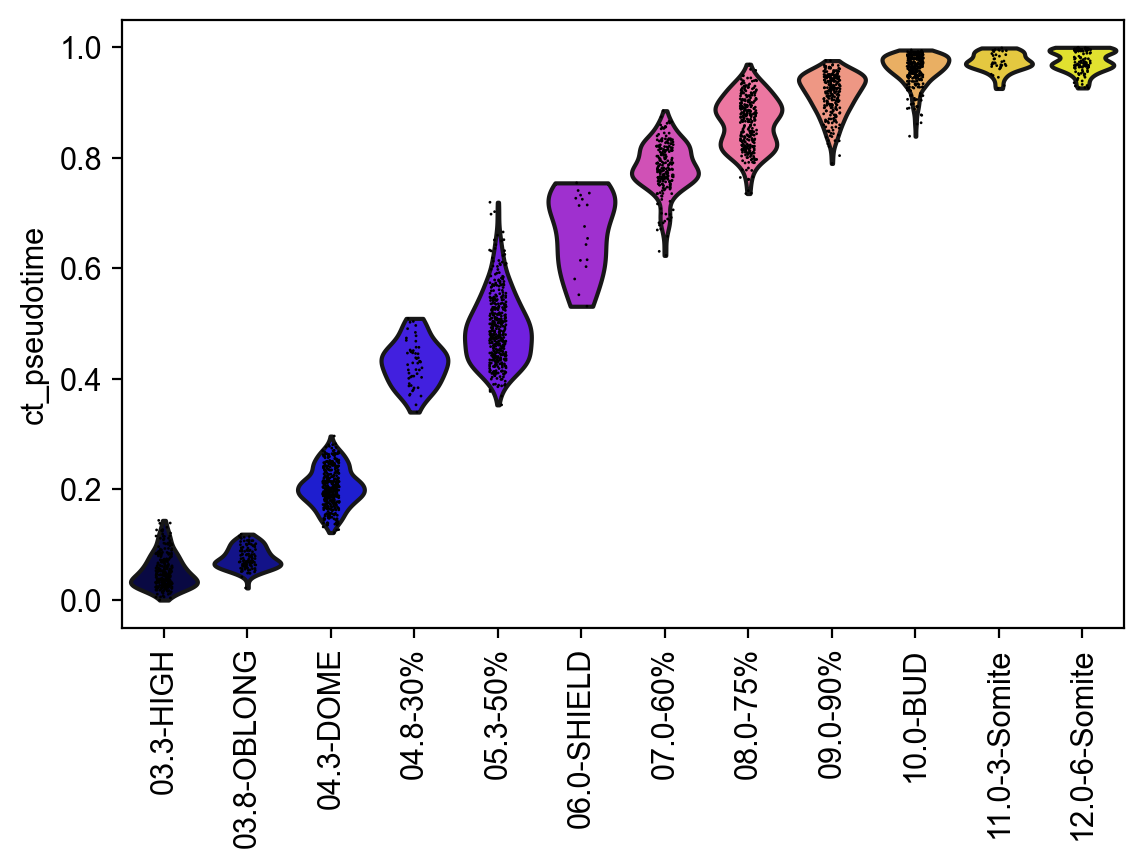

In [13]:
# look at the distribution of CytoTRACE pseudotime in each cluster
sc.pl.violin(adata, keys=["ct_pseudotime"], groupby="Stage", rotation=90)

# these 2 figures validate that CytoTRACE pseudotime can reflect the real differentiation status

In [14]:
# 4.1 Compute a transition matrix
ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)    #Computing transition matrix based on `ct_pseudotime`
adata
# these codes didnt return new values

Computing transition matrix based on `ct_pseudotime`


  0%|          | 0/2434 [00:00<?, ?cell/s]

    Finish (0:00:01)


AnnData object with n_obs × n_vars = 2434 × 13690
    obs: 'Stage', 'gt_terminal_states', 'lineages', 'n_counts', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ct_gene_corr', 'ct_correlates'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'ct_params'
    obsm: 'X_force_directed', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

Projecting transition matrix onto `force_directed`
Adding `adata.obsm['T_fwd_force_directed']`
    Finish (0:00:00)


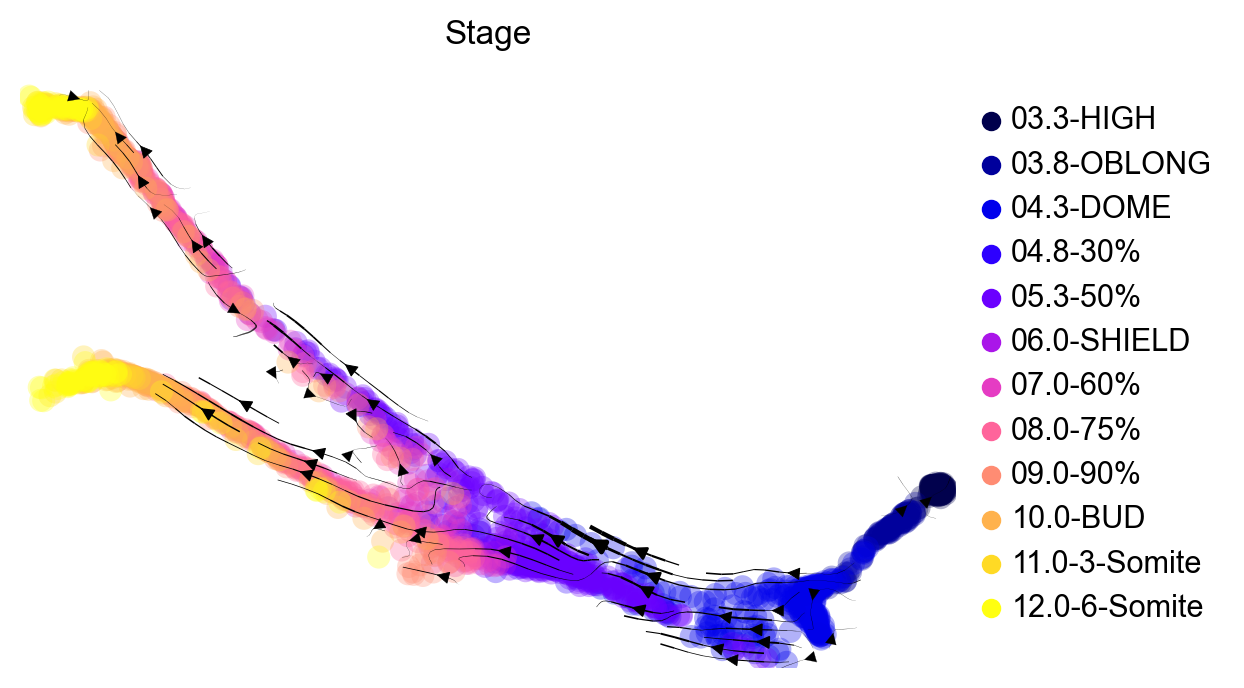

AnnData object with n_obs × n_vars = 2434 × 13690
    obs: 'Stage', 'gt_terminal_states', 'lineages', 'n_counts', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ct_gene_corr', 'ct_correlates'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'ct_params', 'T_fwd_params'
    obsm: 'X_force_directed', 'X_pca', 'T_fwd_force_directed'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [15]:
# 4.2 visualize the transition matrix to check whether it reflect the real differentiation status
ctk.compute_projection(basis="force_directed")    # project the transition matrix on basis (basis can be 'umap')
scv.pl.velocity_embedding_stream(adata, color="Stage", vkey="T_fwd", basis="force_directed", legend_loc="right")    # will show the velocity map-like arrows, but it's not RNA velocity (color can be 'leiden')
# this plot look consistent with the real differentiation status
adata
# these codes return
# uns: 'T_fwd_params'
# obsm: 'T_fwd_force_directed'

Simulating `15` random walks of maximum length `609`


  0%|          | 0/15 [00:00<?, ?sim/s]

    Finish (0:00:01)
Plotting random walks


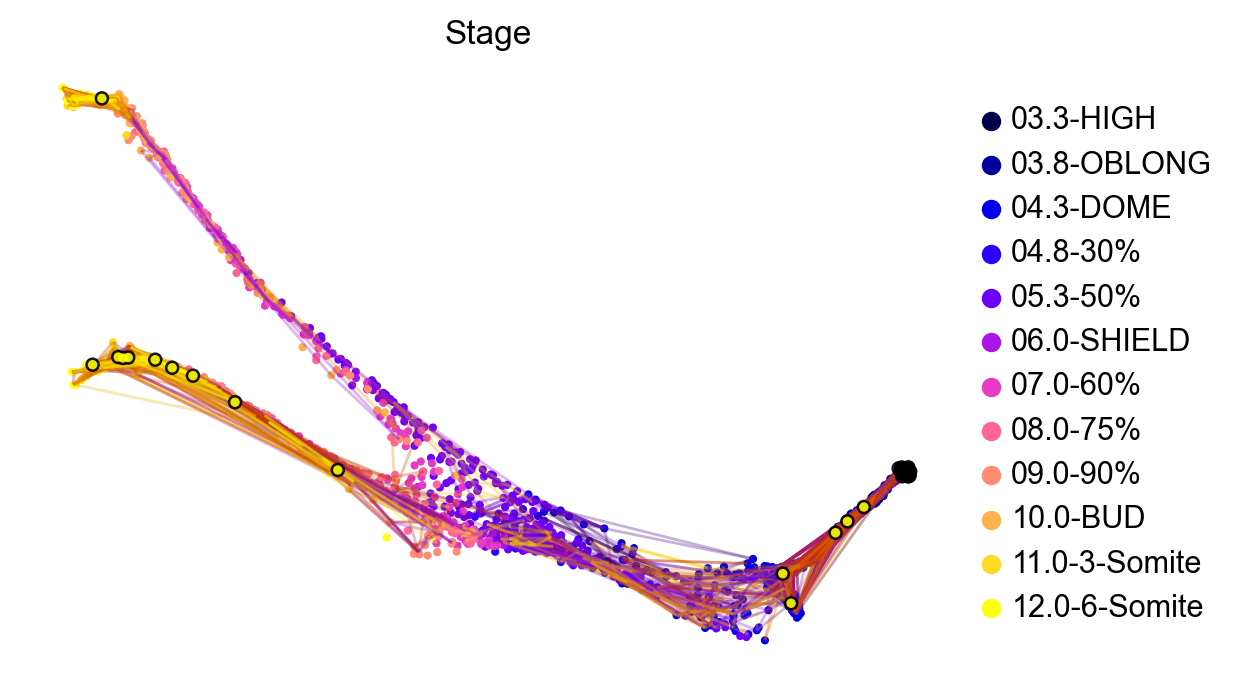

In [16]:
# Another way to visualize the transition matrix: draw some cells from the early stage and use them as starting cells to simulate random walks
ctk.plot_random_walks(n_sims=15, start_ixs={"Stage": "03.3-HIGH"}, basis="force_directed", color="Stage", legend_loc="right", seed=1)
# Black dots stands for starting cells, yellow dots stands for end cells, this plot also looks consistent with the real differentiation status
# start_ixs is python dictionary, input both key and its value, for example, start_ixs={'leiden':'0'}

# these 2 figures validate that CytoTRACE pseudotime generated transition matrix can reflect the real differentiation status

In [17]:
# 5. Use estimator to compute macrostates
from cellrank.tl.estimators import GPCCA
g_fwd = GPCCA(ctk)
print(g_fwd)
adata
# these codes return
# uns: 'T_fwd_params'
# obsm: 'T_fwd_force_directed'

GPCCA[n=2434, kernel=<CytoTRACEKernel[dnorm=False, scheme=soft, b=10.0, nu=0.5]>]


AnnData object with n_obs × n_vars = 2434 × 13690
    obs: 'Stage', 'gt_terminal_states', 'lineages', 'n_counts', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ct_gene_corr', 'ct_correlates'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'ct_params', 'T_fwd_params'
    obsm: 'X_force_directed', 'X_pca', 'T_fwd_force_directed'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:05)


AnnData object with n_obs × n_vars = 2434 × 13690
    obs: 'Stage', 'gt_terminal_states', 'lineages', 'n_counts', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ct_gene_corr', 'ct_correlates'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'ct_params', 'T_fwd_params', 'schur_matrix_fwd', 'eigendecomposition_fwd'
    obsm: 'X_force_directed', 'X_pca', 'T_fwd_force_directed', 'schur_vectors_fwd'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

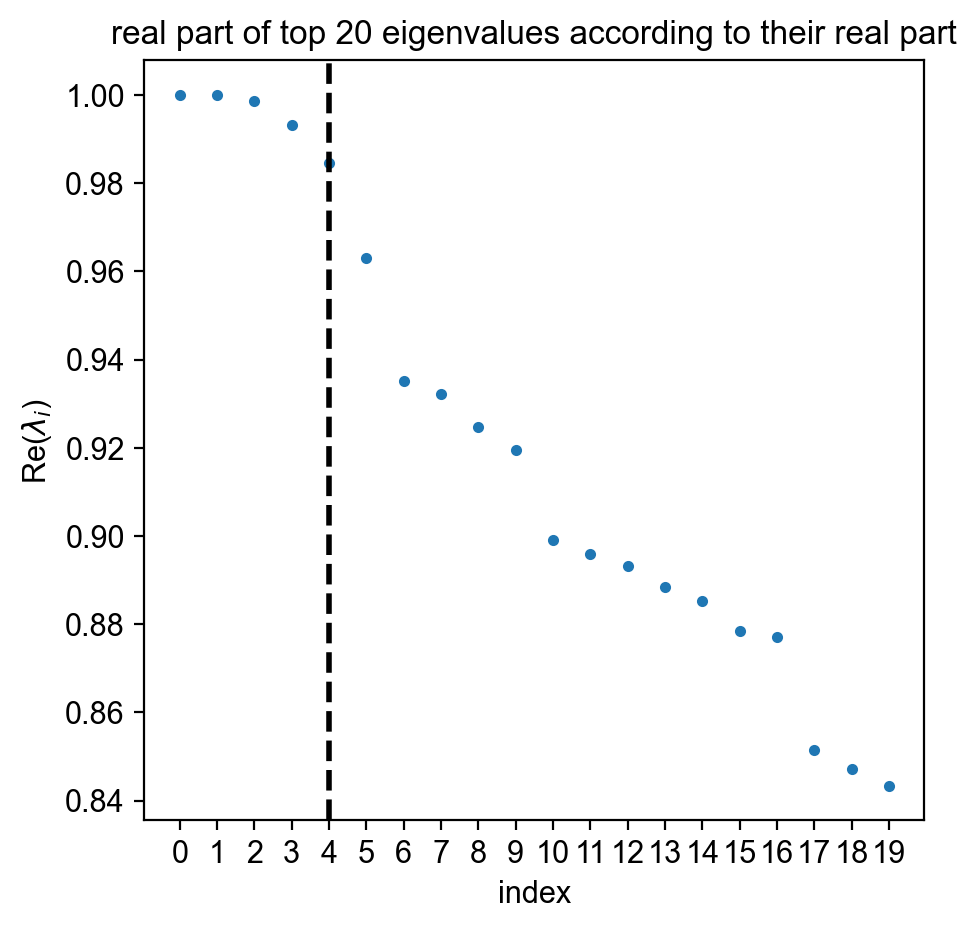

In [18]:
# compute a Schur decomposition
g_fwd.compute_schur(n_components=20, method='krylov')
g_fwd.plot_spectrum(real_only=True)
# the black dash line is the eigengap inferred average 5 eigenvalues, so you should compute 5 macrostates as a starting point.
# Keep in mind the eigengap statistic is a heuristic, so take this 5 eigenvalues as a starting point to your analysis.
adata
# these codes return
# uns: 'schur_matrix_fwd', 'eigendecomposition_fwd'
# obsm: 'schur_vectors_fwd'

Computing `4` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


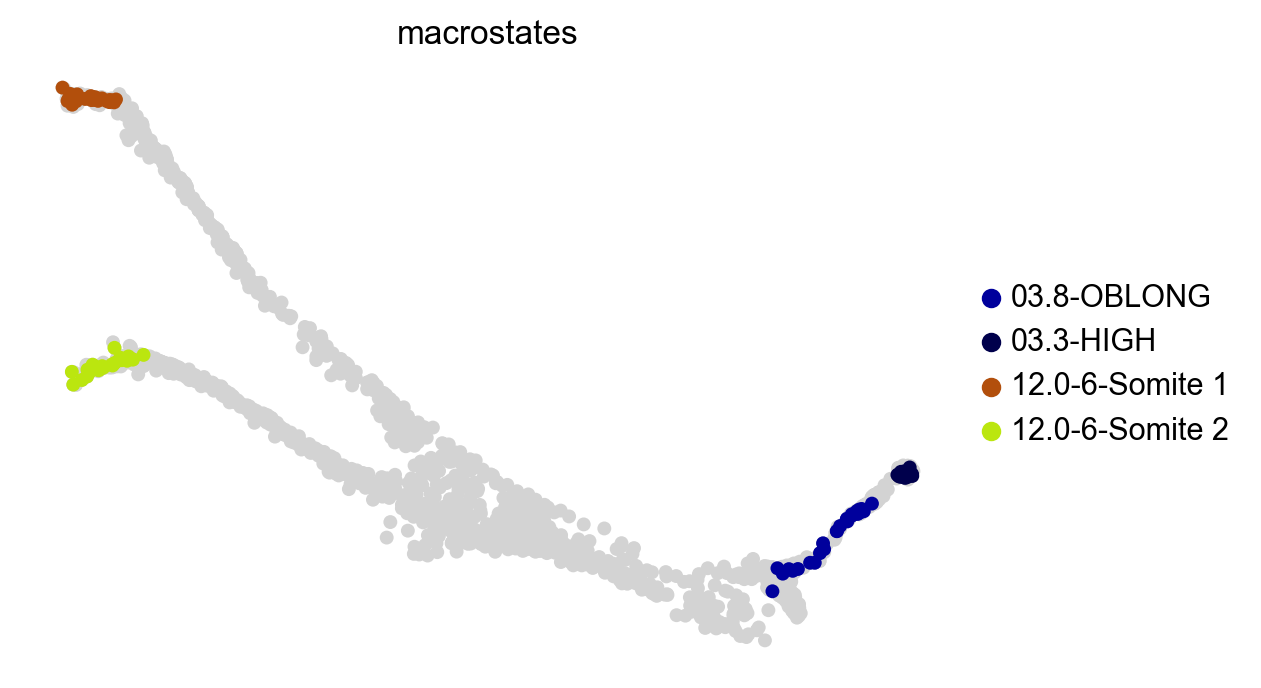

AnnData object with n_obs × n_vars = 2434 × 13690
    obs: 'Stage', 'gt_terminal_states', 'lineages', 'n_counts', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ct_gene_corr', 'ct_correlates'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'ct_params', 'T_fwd_params', 'schur_matrix_fwd', 'eigendecomposition_fwd', 'coarse_fwd'
    obsm: 'X_force_directed', 'X_pca', 'T_fwd_force_directed', 'schur_vectors_fwd'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [19]:
# compute macrostates
g_fwd.compute_macrostates(n_states=5, cluster_key="Stage")    # compute 5 macrostates, determined by the eigengap, change cluster_key to 'lineages' doesn't affect macrostates themselves
g_fwd.plot_macrostates(discrete=True, legend_loc="right", size=100, basis="force_directed")    # show the marcrostates, consistent with the real differentiation status
adata
# these codes return
# uns: 'coarse_fwd'

AnnData object with n_obs × n_vars = 2434 × 13690
    obs: 'Stage', 'gt_terminal_states', 'lineages', 'n_counts', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ct_gene_corr', 'ct_correlates'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'ct_params', 'T_fwd_params', 'schur_matrix_fwd', 'eigendecomposition_fwd', 'coarse_fwd'
    obsm: 'X_force_directed', 'X_pca', 'T_fwd_force_directed', 'schur_vectors_fwd'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

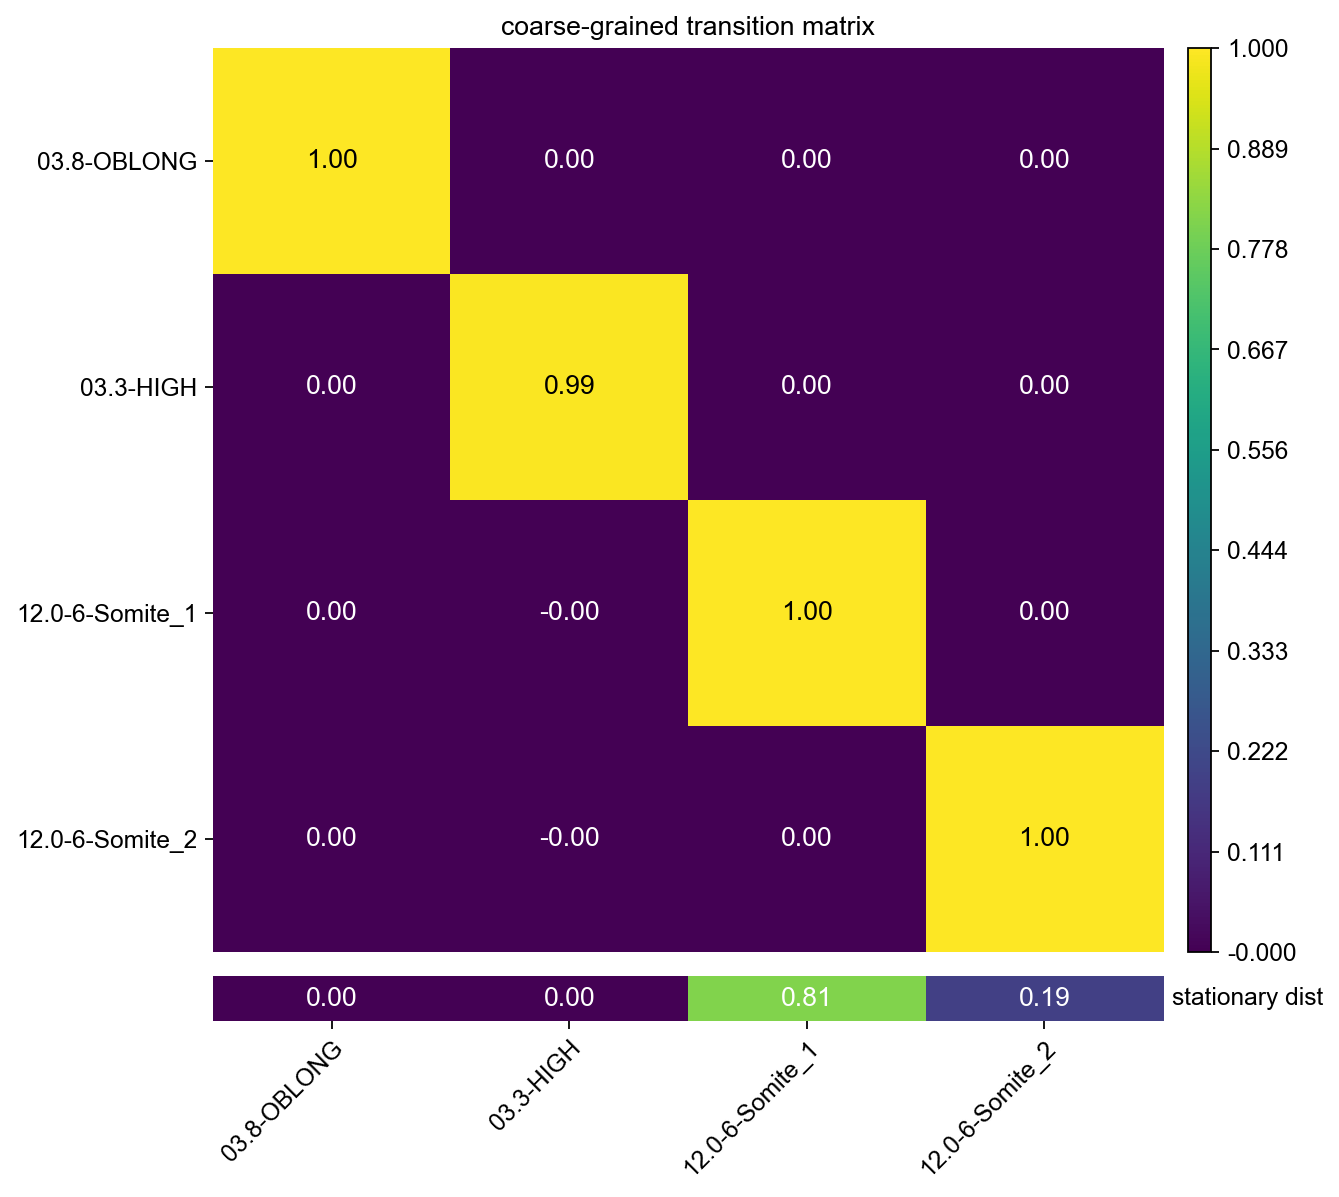

In [20]:
# confirm the early state is stable by looking at coarse transition probabilities among macrostates
g_fwd.plot_coarse_T()
adata
# these codes didnt return new values

In [21]:
# set the '12.0-6-Somite' stage as the terminal states
g_fwd.set_terminal_states_from_macrostates(names=['12.0-6-Somite_1', '12.0-6-Somite_2'])    # the order you set and the color you choose here matters the circular_projection
# different ways to set the terminal state:
    # estimator.compute_terminal_states(): automatically selects the terminal states from the set of macrostates via a stability criterion.
    # estimator.set_terminal_states_from_macrostates(): manually restrict the macrostates by passing a list of macrostate-names that you know are terminal in your data.
    # estimator.set_terminal_states(): manually set the terminal states, without computing macrostates, entirely manually.
adata
# these codes return
# obs: 'terminal_states', 'terminal_states_probs'
# uns: 'terminal_states_colors'
# obsm: 'terminal_states_memberships'

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


AnnData object with n_obs × n_vars = 2434 × 13690
    obs: 'Stage', 'gt_terminal_states', 'lineages', 'n_counts', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime', 'terminal_states', 'terminal_states_probs'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ct_gene_corr', 'ct_correlates'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'ct_params', 'T_fwd_params', 'schur_matrix_fwd', 'eigendecomposition_fwd', 'coarse_fwd', 'terminal_states_colors'
    obsm: 'X_force_directed', 'X_pca', 'T_fwd_force_directed', 'schur_vectors_fwd', 'terminal_states_memberships'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [22]:
g_fwd._set_initial_states_from_macrostates(names=['03.8-OBLONG', '03.3-HIGH'])
# different ways to set the initial state:
    # estimator._compute_initial_states(): automatically selects the initial states from the set of macrostates via a stability criterion.
    # estimator._set_initial_states_from_macrostates(): manually restrict the macrostates by passing a list of macrostate-names that you know are initial in your data.
    # no estimator._set_initial_states()
adata
# these codes return
# obs: 'initial_states', 'initial_states_probs'
# uns: 'initial_states_colors'

Adding `adata.obs['initial_states']`
       `adata.obs['initial_states_colors']`



AnnData object with n_obs × n_vars = 2434 × 13690
    obs: 'Stage', 'gt_terminal_states', 'lineages', 'n_counts', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime', 'terminal_states', 'terminal_states_probs', 'initial_states', 'initial_states_probs'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ct_gene_corr', 'ct_correlates'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'ct_params', 'T_fwd_params', 'schur_matrix_fwd', 'eigendecomposition_fwd', 'coarse_fwd', 'terminal_states_colors', 'initial_states_colors'
    obsm: 'X_force_directed', 'X_pca', 'T_fwd_force_directed', 'schur_vectors_fwd', 'terminal_states_memberships'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [23]:
# 6. Compute fate map according to the manually set terminal states
g_fwd.compute_absorption_probabilities(n_jobs=16)
# solver=, could be 'direct', 'gmres', 'lgmres', 'bicgstab', 'gcrotmk', default is 'gmres', change solver if 'gmres' doesnt work for ill-conditioned matrices.
# keys=, manually set terminal states, otherwise it will use all macrostates.
# tol=, Convergence tolerance for the iterative solver. The default is fine for most cases, only consider decreasing this for severely ill-conditioned matrices.
# preconditioner=, recommend preconditioner='ilu' for ill-conditioned matrices.
adata
# these codes return
# obsm: 'to_terminal_states'

Computing absorption probabilities
Defaulting to `'gmres'` solver.


  0%|          | 0/2 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:05)


AnnData object with n_obs × n_vars = 2434 × 13690
    obs: 'Stage', 'gt_terminal_states', 'lineages', 'n_counts', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime', 'terminal_states', 'terminal_states_probs', 'initial_states', 'initial_states_probs'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ct_gene_corr', 'ct_correlates'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'ct_params', 'T_fwd_params', 'schur_matrix_fwd', 'eigendecomposition_fwd', 'coarse_fwd', 'terminal_states_colors', 'initial_states_colors'
    obsm: 'X_force_directed', 'X_pca', 'T_fwd_force_directed', 'schur_vectors_fwd', 'terminal_states_memberships', 'to_terminal_states'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

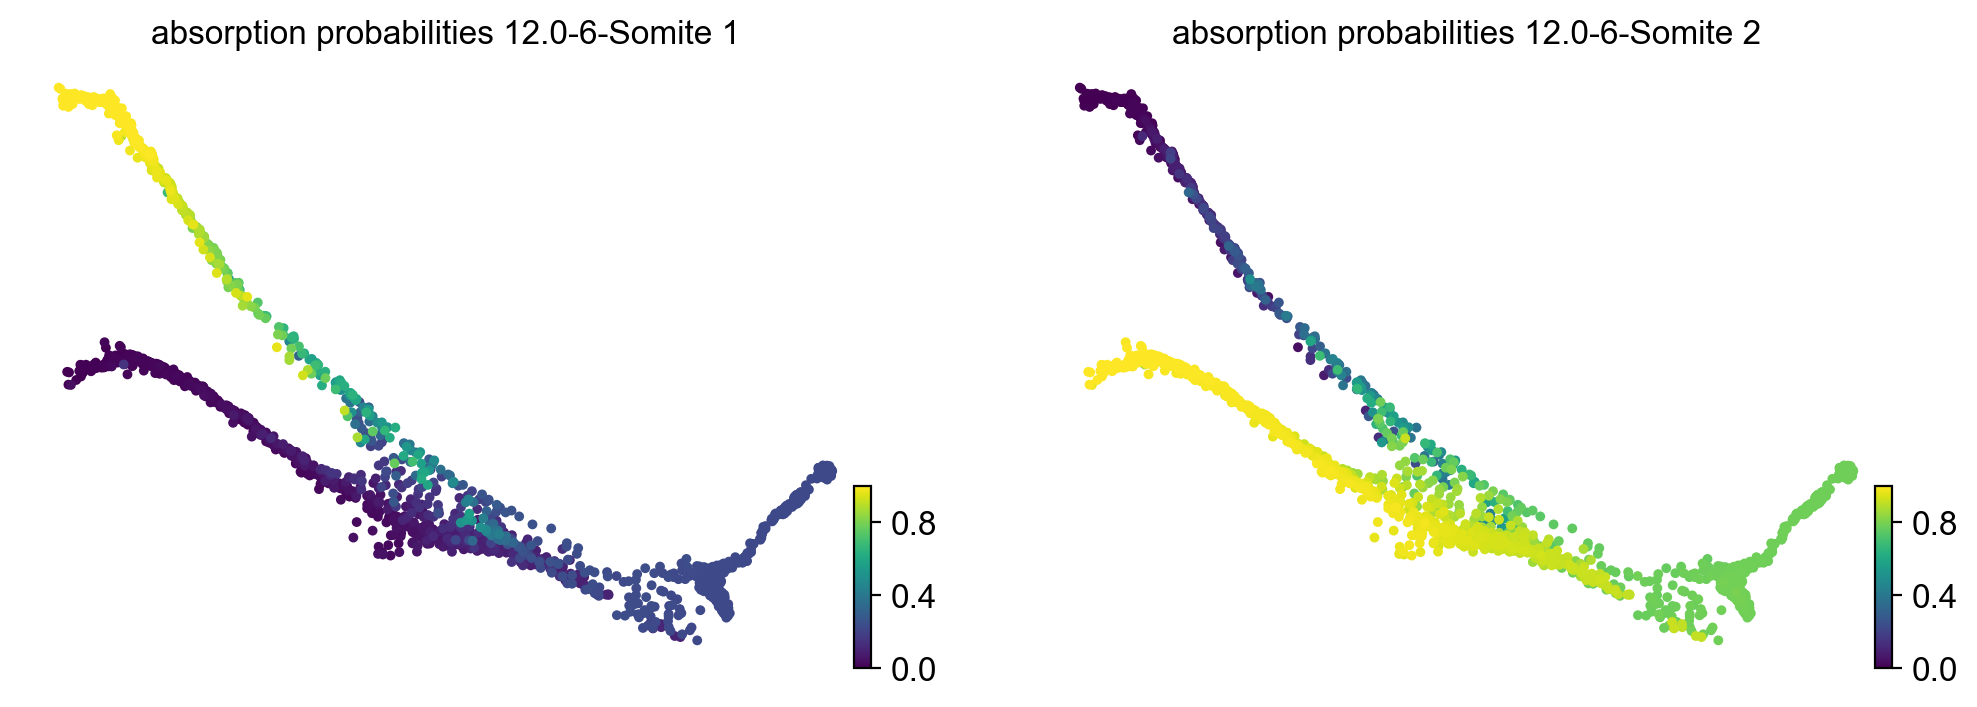

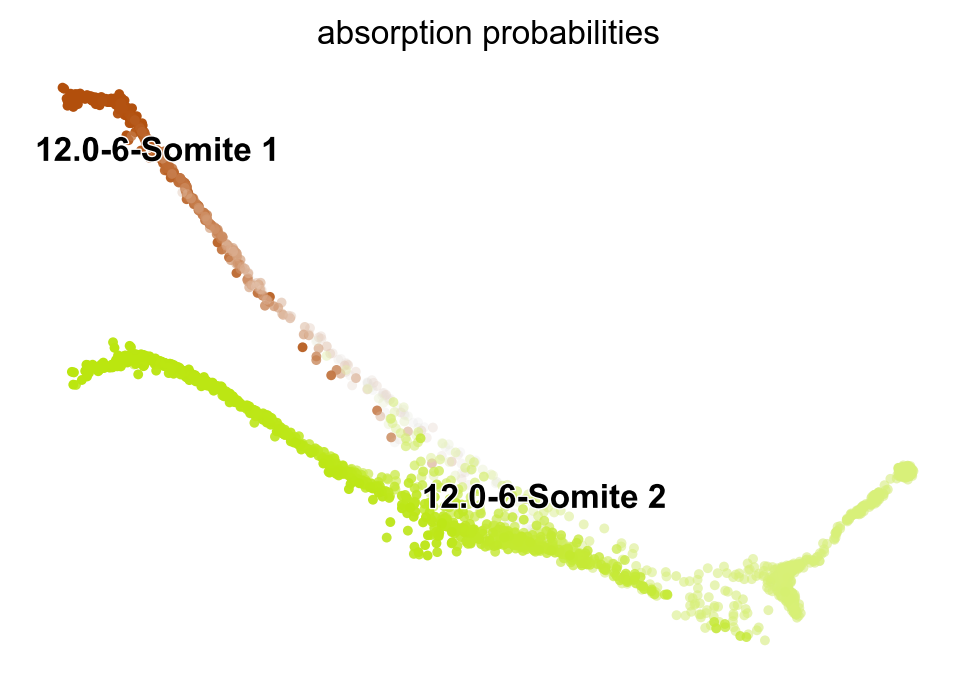

In [24]:
g_fwd.plot_absorption_probabilities(same_plot=False, size=50, basis="force_directed")    # size=50 means dot size is 50
g_fwd.plot_absorption_probabilities(same_plot=True, size=50, basis="force_directed")

In [28]:
adata

AnnData object with n_obs × n_vars = 2434 × 13690
    obs: 'Stage', 'gt_terminal_states', 'lineages', 'n_counts', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime', 'terminal_states', 'terminal_states_probs', 'initial_states', 'initial_states_probs', 'clusters_gradients'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ct_gene_corr', 'ct_correlates'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'ct_params', 'T_fwd_params', 'schur_matrix_fwd', 'eigendecomposition_fwd', 'coarse_fwd', 'terminal_states_colors', 'initial_states_colors', 'clusters_gradients_colors', 'velocity_graph', 'paga', 'Stage_sizes'
    obsm: 'X_force_directed', 'X_pca', 'T_fwd_force_directed', 'schur_vectors_fwd', 'terminal_states_memberships', 'to_terminal_states'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [34]:
# 7. ct_pseudotime-directed PAGA
adata.uns['velocity_graph'] = adata.obsp['connectivities']    # key step
# manually copy adata.obsp['connectivities'] to adata.uns['velocity_graph'], because scv.tl.paga() calls vkey='velocity', vkey means the parameters name has this vkey
adata

AnnData object with n_obs × n_vars = 2434 × 13690
    obs: 'Stage', 'gt_terminal_states', 'lineages', 'n_counts', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime', 'terminal_states', 'terminal_states_probs', 'initial_states', 'initial_states_probs', 'clusters_gradients'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ct_gene_corr', 'ct_correlates'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'ct_params', 'T_fwd_params', 'schur_matrix_fwd', 'eigendecomposition_fwd', 'coarse_fwd', 'terminal_states_colors', 'initial_states_colors', 'clusters_gradients_colors', 'velocity_graph', 'paga', 'Stage_sizes'
    obsm: 'X_force_directed', 'X_pca', 'T_fwd_force_directed', 'schur_vectors_fwd', 'terminal_states_memberships', 'to_terminal_states'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

running PAGA using priors: ['ct_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


StopIteration: 

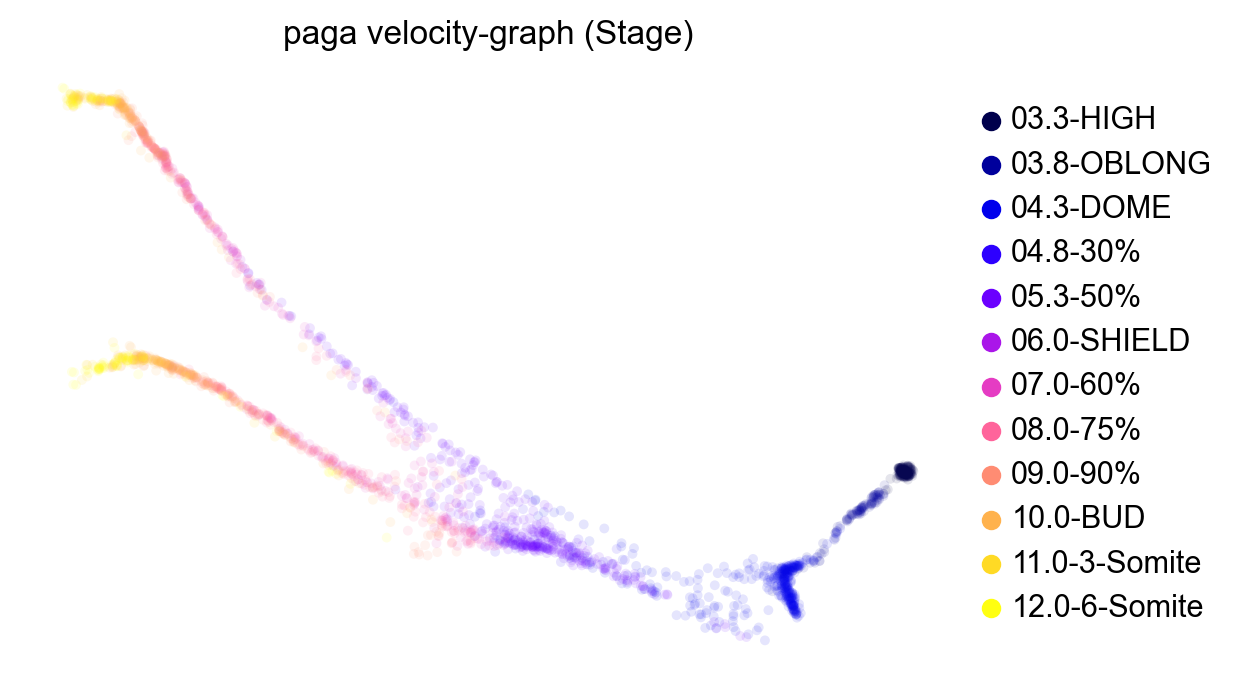

In [35]:
scv.tl.paga(adata, groups='Stage', vkey='velocity', use_time_prior='ct_pseudotime')
# can add root_key="initial_states_probs" or end_key="terminal_states_probs" into scv.tl.paga() if g_fwd.set_terminal_states_from_macrostates() or g_fwd._set_initial_states_from_macrostates() were proceeded before
## scv.tl.paga(adata, groups='Stage', vkey='velocity', use_time_prior="ct_pseudotime", root_key="initial_states_probs", end_key="terminal_states_probs")
scv.pl.paga(adata, basis='force_directed', vkey='velocity', color='Stage', node_size_scale=1.5, min_edge_width=2, use_raw=False, size=50, alpha=0.1)

In [ ]:
# 8. Fate-probability-directed PAGA
cr.pl.cluster_fates(adata, mode="paga_pie", cluster_key='Stage', basis="force_directed",
                    legend_kwargs={"loc": "top right out"}, legend_loc="top left out", node_size_scale=5, edge_width_scale=1, max_edge_width=4, title="directed PAGA")

In [ ]:
# 9. Fate circular map
cr.pl.circular_projection(adata, keys="Stage", legend_loc="right")

In [ ]:
# 10. Compute lineage drivers
cr.tl.lineage_drivers(adata)    # the concept of lineage drivers is similar to the differential velocity genes
# use culsters= to calculate lineage drivers for specific clusters

In [ ]:
# plot the top5 driver genes (based on the correlation) for the 'Stage' cluster 12.0-6-Somite
cr.pl.lineage_drivers(adata, lineage="12.0-6-Somite", n_genes=5)

In [ ]:
# 11. check whether DPT are consistent with CellRank fate map
# use "03.3-HIGH" as root clusters for computing DPT, should run g_fwd._set_initial_states_from_macrostates() before
root_idx = np.where(adata.obs["initial_states"] == "03.3-HIGH")[0][0]
adata.uns["iroot"] = root_idx
sc.tl.dpt(adata)

In [ ]:
# different pseudotime maps should be consistent
scv.pl.scatter(adata, color=["Stage", root_idx, "ct_pseudotime", "dpt_pseudotime"],
               cmap="viridis", perc=[2, 98], colorbar=True, rescale_color=[0, 1], title=["Stage", "root cell", "ct_pseudotime", "dpt_pseudotime"])

In [ ]:
# 12. Gene expression trends, use the computed probabilities to smooth gene expression trends (pseudotime) along lineages
# plot dynamics of interated genes in CytoTRACE pseudotime along individual trajectories
model = cr.ul.models.GAM(adata)
cr.pl.gene_trends(adata, model=model, data_key="X", genes=["A2M"], lineages=None, time_key="ct_pseudotime", same_plot=True, hide_cells=True, n_test_points=200, n_jobs=16)

In [ ]:
# 13. visualize the lineage drivers in a heatmap
# use 03.3-HIGH lineage for example, we smooth gene expression for the putative 03.3-HIGH-drivers in pseudotime, using cell-level weights the 03.3-HIGH fate probabilities
cr.pl.heatmap(adata, model, genes=adata.varm['terminal_lineage_drivers']["03.3-HIGH_corr"].sort_values(ascending=False).index[:100], time_key="ct_pseudotime",
              show_absorption_probabilities=True, lineages="03.3-HIGH", n_jobs=1, backend="loky")